In [1]:
# Importing Dependencies
from Pipeline_Support.ETL_MasterFunction import etl_master
from Pipeline_Support.DimensionalQueries import dimquery
from Pipeline_Support.FactSnapshot import create_fact_snapshot
from Pipeline_Support.FTSUpload import upload_fact_table
from IPython.display import Image

## Populating Database
First we need to generate synthetic data from Mockaroo for our defined database schema and upload the datasets on a GitHub repo which we'll be using as a proxy for a database

In [2]:
%run Pipeline_Support/DataGen.py

Fetching data for schema: address
Uploading address.csv to GitHub
Fetching data for schema: client
Uploading client.csv to GitHub
Fetching data for schema: agent
Uploading agent.csv to GitHub
Fetching data for schema: owner
Uploading owner.csv to GitHub
Fetching data for schema: features
Uploading features.csv to GitHub
Fetching data for schema: property
Uploading property.csv to GitHub
Fetching data for schema: maintenance
Uploading maintenance.csv to GitHub
Fetching data for schema: visit
Uploading visit.csv to GitHub
Fetching data for schema: commission
Uploading commission.csv to GitHub
Fetching data for schema: sale
Uploading sale.csv to GitHub
Fetching data for schema: contract
Uploading contract.csv to GitHub
Fetching data for schema: rent
Uploading rent.csv to GitHub
Fetching data for schema: admin
Uploading admin.csv to GitHub
All datasets have been uploaded.


### ETL
The following operations are done in the ETL Pipeline:
* It fetches the datasets (csv tables) from the GitHub Repo and stores all of them as dataframes in a dictionary.
* Then it treats for the missing values in each of the dataframes: some of the features like rent_amount, sale_amount, commission_value, commission_rate is filled logically, other numeric features are imputed through KNN imputer (each dataframe separately), and finally categorical features are filled with modal value.
* Then it corrects the data types for various columns in each dataframe where needed.
* Then the star schema is created as per the blueprint already defined:
    * First Date dimension is created which has dates generated from 01/01/2021 to 31/12/2023 with a unique data key.
    * Then Location dimension is generated and location id from the oltp table is kept along with a unique location.
    * Similarly, Agent, Property Details, and Listing dimensions are generated.
    * Then the fact table is generated by doing multiple joins (left dataframe merges) to get a big dataframe with all the necessary features required to create facts and then once facts are created unnecessary columns are dropped. Finally, fact dataframe is merged with each dimensional dataframe based on the oltp ids kept in the dimensions to get dimension foreign keys in the fact table. Lastly, oltp ids are dropped from dimensions.
    * *Note: This is a brief summary that doesn't cover every detail of the ETL pipeline. For detailed understanding, check ETL_MasterFunction.py & ETL_SupportFunctions.py*

In [3]:
Dim_Date, Dim_Location, Dim_Agent, Dim_PropertyDetails, Dim_Listing, Fact_Transaction=etl_master()

### Potential Analytical Requirements of the Business
**The following analytical queries are answered through our created data mart (star schema). For further details, check DimensionalQueries.py:**

1- What was the total commission generated through agents handling rental listings in the first quarter of 2021?

2- What was the average time taken to close a listing by agents handling sale listings in all four quarters of 2022?

3- What was average commission rate of the top 5 cities with the most sale transactions in 2023?

4- What was the average time spent in negotiations by agents for the top 3 states with the most rental transactions in 2022 and 2023?

5- What was the average commission generated by middle-aged male and female agents in 2022?

6- What was the average transaction value for Broker Associate in the fourth quarter of 2023? 

7- What was average number of transactions handled by agents who've joined in the past two years?

8- What was the average time taken to close a sale listing where property size was greater 3000 sqft and had more than 4 bedrooms in 2021?

9- What is the average maintenance cost and demand price discount for properties which are built in last two decades?

10- What is the average time taken to close a listing which has a property in a poor condition?

In [4]:
dimquery(Dim_Date=Dim_Date,Dim_Location=Dim_Location,Dim_Agent=Dim_Agent,Dim_PropertyDetails=Dim_PropertyDetails,Dim_Listing=Dim_Listing,Fact_Transaction=Fact_Transaction)

Query 1
+---+------------+
| 0 | 1.3206e+06 |
+---+------------+ 


Query 2
+---+---------+
| 0 | 432.872 |
+---+---------+ 


Query 3
+---+---------------+----------+
| 0 | Charlotte     | 14.7006  |
| 1 | Des Moines    |  6.08795 |
| 2 | New York City |  4.66667 |
| 3 | Tampa         |  3.74724 |
| 4 | Tacoma        |  5       |
+---+---------------+----------+ 


Query 4
+---+------------+----------+
| 0 | Texas      | 101.043  |
| 1 | California |  51.1935 |
| 2 | Florida    |  42.6154 |
+---+------------+----------+ 


Query 5
+---+--------+---------+
| 0 | Female | 24409.4 |
| 1 | Male   | 24966.2 |
+---+--------+---------+ 


Query 6
+---+--------+
| 0 | 332720 |
+---+--------+ 


Query 7
+---+---------+
| 0 | 8.17544 |
+---+---------+ 


Query 8
+---+---------+
| 0 | 137.679 |
+---+---------+ 


Query 9
+---+---------+----------+
| 0 | 5291.32 | -18.8476 |
+---+---------+----------+ 


Query 10
+---+---------+
| 0 | 430.704 |
+---+---------+ 




### Fact Table Snapshot
Fact table snapshot is created by simply joining the fact table with dimensional tables based on the dimensional keys and which gives in return a big dataframe that has all the dimensional attributes of all dimensional tables within the fact table (based on their respective keys which were foreign keys in the fact table) along with dimensional keys and finally dimensional keys are then dropped from the fact table.

Then the fact table snapshot is uploaded on the GitHub repo as a csv file.

In [5]:
Fact_Snap=create_fact_snapshot(Dim_Date=Dim_Date,Dim_Location=Dim_Location,Dim_Agent=Dim_Agent,Dim_PropertyDetails=Dim_PropertyDetails,Dim_Listing=Dim_Listing,Fact_Transaction=Fact_Transaction)

In [6]:
upload_fact_table(file_content=Fact_Snap.to_csv(index=False),file_name='FactSnapshot.csv')

Fact Table Snapshot Uploaded


### Power BI Dashboard
* First we've connected the Power BI Desktop App with the fact table snapshot uploaded on the GitHub Repo: Get data > Web > "raw.githubusercontent link of fact table snapshot."
* Designed the dashboard on the Desktop App and published it.
* Opened the published dashboard online and published it to web to get a public URL for our dashboard: File > Embed Report > Publish to web.
* Then we went to Pabbly Connect and setup a workflow which will automate the data refresh of our dashboard: **Action** is refresh Power BI dashboard dataset when **Trigger** whenever a commit is pushed on the GitHub repo is trigerred.

In this way when we will run the pipeline again with new data, fact table snapshot csv file on the repo would be updated with the new csv file and our dashboard on the public URL will update itself with the new data!

Also, important to note that the dashboard also shows annual change in the scorecards. For instance, if we select year 2021 and 2022 then it'll show the percentage change in the scorecards between those two years. By default, it shows the change between the max year and the preceeding year. Also, naturally if we just select one year then no change is displayed.

**Dashboard URL : https://app.powerbi.com/view?r=eyJrIjoiZjYyOWQxMWItMGFmNi00M2QyLWIzYWItMDYxOTc3ZjBmNmYwIiwidCI6ImZlZTNiOTE2LTAxYzEtNDk4Ny1hNjQ2LWUxOTM0MzJiOWVhYSIsImMiOjl9**

*Note: The URL here won't show the dashboard for years 2021-2023 anymore and instead show the dashboard for the years 2022-2024 as we've updated the dashboard below in the subsequent iteration of the pipeline with new data. However, you may refer to the snippet below for past reference.*

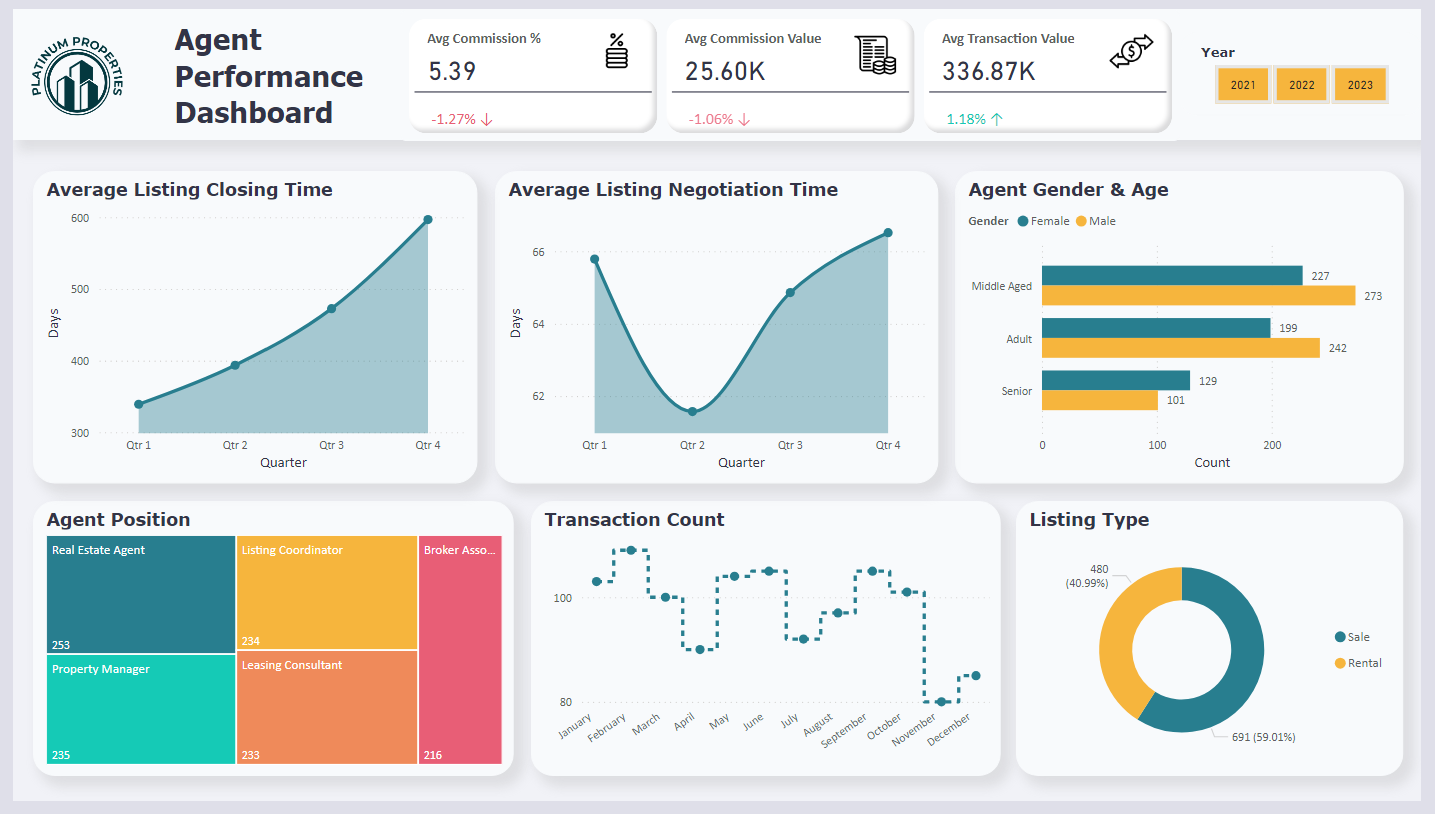

In [7]:
img_path='Dashboard Snips/2021-2023.png'
Image(filename=img_path)

## Updating Database
In the first iteration of our pipeline:
* It connected to the data sources.
* Performed ETL operations to create a data mart from 1st Jan 2021 to 31st Dec 2023 based on Star Schema Dimensional Modelling.
* Addressed potential business analytical queries.
* Created & exported fact table snapshot for Power BI Dashboard.
* Finally, the data mart is now visualized on the Power BI Dashboard.

**However, what if year 2024 has ended and we've new data in our database for that year and we want to update our data mart and the dashboard?**

Suppose that the real-estate management company updates the data mart every year and makes each iteration of the data mart for past 3 years of data and for each iteration also makes a comparison dashboard which compares the newly added year in the updated data mart with the last year of previous data mart. Further, suppose that our first iteration of the pipeline above was the creation of this data mart. So, the data mart was created first time at the end of 2023 and had data for 2021-2023. Then after year 2024, the data mart was updated with new data which was from 2022 to 2024. Also, a comparison dashboard was created which compared the years 2023 and 2024.

To simulate this, we would first update our mockaroo schemas so that it generates data specifically for 2024 (200 rows) and append the generated data with our already existing data (1000 rows) on the database (GitHub Repo) by re-running the data generation script. Then, we would make the following minor tweaks to our ETL process and re-run the whole pipeline as before to get the updated Dashboard.
* Filter the transactions from 01/01/2022 to 31/12/2024 instead of 01/01/2021 to 31/12/2023.
* Create data dimension from 01/01/2022 to 31/12/2024 instead of 01/01/2021 to 31/12/2023.

*Note: For both above changes we only need to modify the start_date & end_date parameters of the ETL master function.*

Because of the Pabbly Connect workflow, we only need to re-run the complete pipeline in this second iteration, when new data is appended in the database, which will result in updating the fact table snapshot on the GitHub repo and this will trigger the dashboard to refresh with new dataset and show visuals for the updated data mart.

In [8]:
%run Pipeline_Support/DataGen.py

Fetching data for schema: address
Uploading address.csv to GitHub
Fetching data for schema: client
Uploading client.csv to GitHub
Fetching data for schema: agent
Uploading agent.csv to GitHub
Fetching data for schema: owner
Uploading owner.csv to GitHub
Fetching data for schema: features
Uploading features.csv to GitHub
Fetching data for schema: property
Uploading property.csv to GitHub
Fetching data for schema: maintenance
Uploading maintenance.csv to GitHub
Fetching data for schema: visit
Uploading visit.csv to GitHub
Fetching data for schema: commission
Uploading commission.csv to GitHub
Fetching data for schema: sale
Uploading sale.csv to GitHub
Fetching data for schema: contract
Uploading contract.csv to GitHub
Fetching data for schema: rent
Uploading rent.csv to GitHub
Fetching data for schema: admin
Uploading admin.csv to GitHub
All datasets have been uploaded.


### ETL
The following operations are done in the ETL Pipeline:
* It fetches the datasets (csv tables) from the GitHub Repo and stores all of them as dataframes in a dictionary.
* Then it treats for the missing values in each of the dataframes: some of the features like rent_amount, sale_amount, commission_value, commission_rate is filled logically, other numeric features are imputed through KNN imputer (each dataframe separately), and finally categorical features are filled with modal value.
* Then it corrects the data types for various columns in each dataframe where needed.
* Then the star schema is created as per the blueprint already defined:
    * First Date dimension is created which has dates generated from 01/01/2022 to 31/12/2024 with a unique data key.
    * Then Location dimension is generated and location id from the oltp table is kept along with a unique location.
    * Similarly, Agent, Property Details, and Listing dimensions are generated.
    * Then the fact table is generated by doing multiple joins (left dataframe merges) to get a big dataframe with all the necessary features required to create facts and then once facts are created unnecessary columns are dropped. Finally, fact dataframe is merged with each dimensional dataframe based on the oltp ids kept in the dimensions to get dimension foreign keys in the fact table. Lastly, oltp ids are dropped from dimensions.
    * *Note: This is a brief summary that doesn't cover every detail of the ETL pipeline. For detailed understanding, check ETL_MasterFunction.py & ETL_SupportFunctions.py*

In [9]:
Dim_Date, Dim_Location, Dim_Agent, Dim_PropertyDetails, Dim_Listing, Fact_Transaction=etl_master()

### Potential Analytical Requirements of the Business
**The following analytical queries are answered through our created data mart (star schema). For further details, check DimensionalQueries.py:**			

1- What was the total commission generated through agents handling rental listings in the first quarter of 2022?

2- What was the average time taken to close a listing by agents handling sale listings in all four quarters of 2022?

3- What was average commission rate of the top 5 cities with the most sale transactions in 2023?

4- What was the average time spent in negotiations by agents for the top 3 states with the most rental transactions in 2022 and 2023?

5- What was the average commission generated by middle-aged male and female agents in 2022?

6- What was the average transaction value for Broker Associate in the fourth quarter of 2023? 

7- What was average number of transactions handled by agents who've joined in the past two years?

8- What was the average time taken to close a sale listing where property size was greater 3000 sqft and had more than 4 bedrooms in 2022?

9- What is the average maintenance cost and demand price discount for properties which are built in last two decades?

10- What is the average time taken to close a listing which has a property in a poor condition?

In [10]:
dimquery(Dim_Date=Dim_Date,Dim_Location=Dim_Location,Dim_Agent=Dim_Agent,Dim_PropertyDetails=Dim_PropertyDetails,Dim_Listing=Dim_Listing,Fact_Transaction=Fact_Transaction)

Query 1
+---+-------------+
| 0 | 1.11674e+06 |
+---+-------------+ 


Query 2
+---+---------+
| 0 | 432.872 |
+---+---------+ 


Query 3
+---+---------------+----------+
| 0 | Charlotte     | 14.7006  |
| 1 | Des Moines    |  6.08795 |
| 2 | New York City |  4.66667 |
| 3 | Tampa         |  3.74724 |
| 4 | Tacoma        |  5       |
+---+---------------+----------+ 


Query 4
+---+------------+---------+
| 0 | Texas      | 93.7273 |
| 1 | California | 66.0208 |
| 2 | New York   | 62.0227 |
+---+------------+---------+ 


Query 5
+---+--------+---------+
| 0 | Female | 24409.4 |
| 1 | Male   | 24966.2 |
+---+--------+---------+ 


Query 6
+---+--------+
| 0 | 332720 |
+---+--------+ 


Query 7
+---+---------+
| 0 | 7.63095 |
+---+---------+ 


Query 8
+---+--------+
| 0 | 453.88 |
+---+--------+ 


Query 9
+---+---------+---------+
| 0 | 5166.53 | -30.797 |
+---+---------+---------+ 


Query 10
+---+---------+
| 0 | 535.019 |
+---+---------+ 




### Fact Table Snapshot
Fact table snapshot is created by simply joining the fact table with dimensional tables based on the dimensional keys and which gives in return a big dataframe that has all the dimensional attributes of all dimensional tables within the fact table (based on their respective keys which were foreign keys in the fact table) along with dimensional keys and finally dimensional keys are then dropped from the fact table.

Then the fact table snapshot is uploaded on the GitHub repo as a csv file which in this second iteration would simply replace the previous csv file.

In [11]:
Fact_Snap=create_fact_snapshot(Dim_Date=Dim_Date,Dim_Location=Dim_Location,Dim_Agent=Dim_Agent,Dim_PropertyDetails=Dim_PropertyDetails,Dim_Listing=Dim_Listing,Fact_Transaction=Fact_Transaction)

In [13]:
upload_fact_table(file_content=Fact_Snap.to_csv(index=False),file_name='FactSnapshot.csv')

Fact Table Snapshot Updated


### Power BI Dashboard
Now that we have ran the pipeline again because new data is available in the database and it is time for the annual update of our data mart, already existing fact table snapshot csv file on the GitHub repo is replaced with the updated fact table snapshot and our dashboard on the public URL has updated itself with the new data. This is because of the Pabbly Connect workflow which refreshes the Power BI dashboard when triggered by a commit push on the GitHub repo (commit in this case is the replacement of the fact table snapshot csv file).

Also, important to note that the dashboard also shows annual change in the scorecards. For instance, if we select year 2022 and 2023 then it'll show the percentage change in the scorecards between those two years. By default, it shows the change between the max year and the preceeding year. Also, naturally if we just select one year then no change is displayed.

**Dashboard URL : https://app.powerbi.com/view?r=eyJrIjoiZjYyOWQxMWItMGFmNi00M2QyLWIzYWItMDYxOTc3ZjBmNmYwIiwidCI6ImZlZTNiOTE2LTAxYzEtNDk4Ny1hNjQ2LWUxOTM0MzJiOWVhYSIsImMiOjl9**

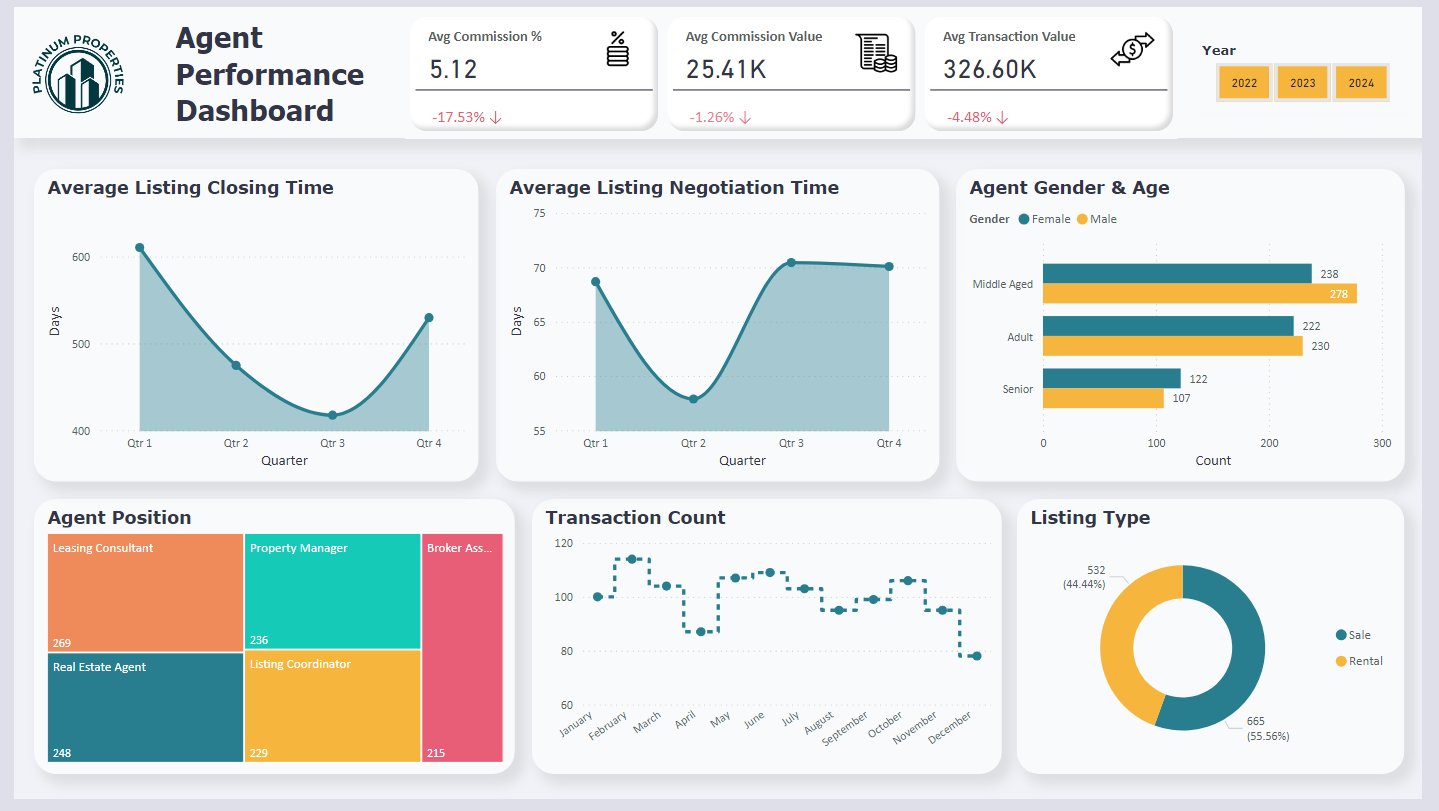

In [14]:
img_path='Dashboard Snips/2022-2024.png'
Image(filename=img_path)

### Pabbly Connect Worflow

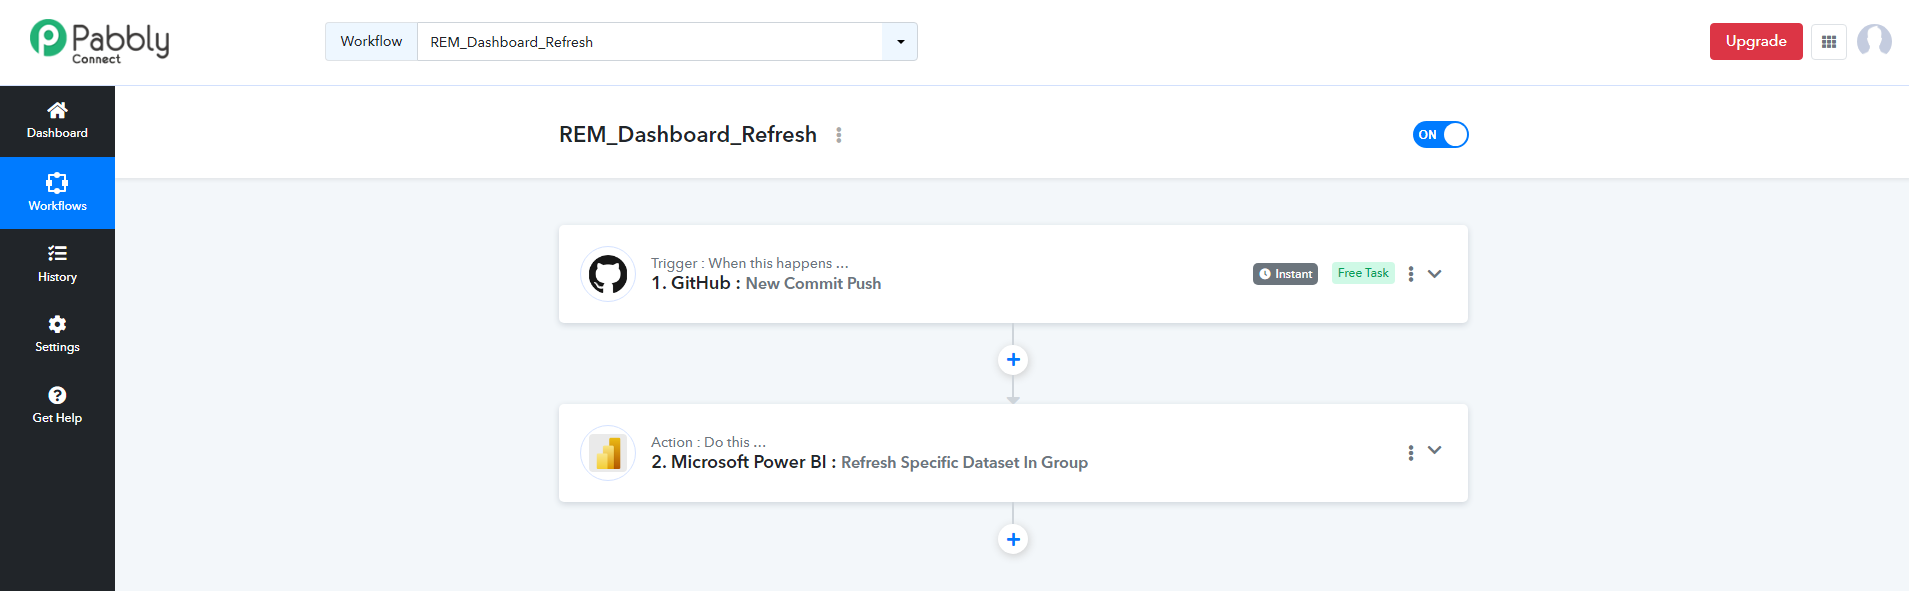

In [15]:
img_path='Pabbly Connect Workflow.png'
Image(filename=img_path)